<a href="https://colab.research.google.com/github/Nhatkhang/Machine_learning_CBD/blob/Project_assignments/Lung_cancer_project_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!kaggle datasets download -d nguyenhoangnhatkhang/luna16-106-files

100% 7.18G/7.21G [02:29<00:01, 23.4MB/s]
100% 7.21G/7.21G [02:29<00:00, 51.8MB/s]


In [0]:
!ls

kaggle.json  luna16-106-files.zip  sample_data


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/content/luna16-106-files.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
!ls

candidates_V2  kaggle.json  LUN_16_106_files  luna16-106-files.zip  sample_data


In [0]:
pip install SimpleITK

     |████████████████████████████████| 42.5MB 102kB/s 


# **LUNG CANCER PROJECT**




Use Deep Learning and this dataset to determine if the patient will be
diagnosed with lung cancer. You are given over a thousand
low-dose CT images from high-risk patients in DICOM format.
Each image contains a series with multiple axial slices of the
chest cavity. Each image has a variable number of 2D slices,
which can vary based on the machine taking the scan and patient.
The DICOM files have a header that contains the necessary
information about the patient id, as well as scan parameters such
as the slice thickness. The project should follow the guideline as:

1. Pre-process the image data
2. Perform data exploration to learn as much about the data (include
visualization in 2D, 3D, segmentation, bisecting images, rotation, etc.)
3. Apply CNN with classification_report to determine the result.
4. Tune the models for better performance.
5. Using Object Localization, locate precisely the location of tumor (if
positive).
6. Identify the correct measurement the size of tumor (in terms of
diameter, thickness, shapes, etc.).
7. Using test images, evaluate the performance of models.

## Introduction
This project aims to create a classifier of cancer for patients based on the DICOM CT scan images. The CNN is used in this report to predict the outcome of high risk patients. Firstly, we will describe the image data in the **Data exploration** section. After that, the CNN model will be constructed and train to fit our data in **CNN model** section. An evaluation of the model will be presented latter. 

## Data Exploration

In [0]:
import SimpleITK as sitk
import csv
import os
from PIL import Image
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import plotly.offline as py
from sklearn.metrics import precision_recall_fscore_support
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi
import warnings
warnings.filterwarnings("ignore")

We define now a function to open the image, store it into a numpy array and extract the some info:
- Origin
- Pixel Spacing

In [0]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing

We will take the list of the patient as follow:

In [0]:
INPUT_FOLDER = '/content/LUN_16_106_files/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(len(patients))
# 106 files mhd

106


In [0]:
count=[]
for i in range(len(patients)):
  count.append(load_itk_image(INPUT_FOLDER+patients[i]+'/'+patients[i])[0].shape[0])


Text(0.5, 0, 'range(0, 106)')

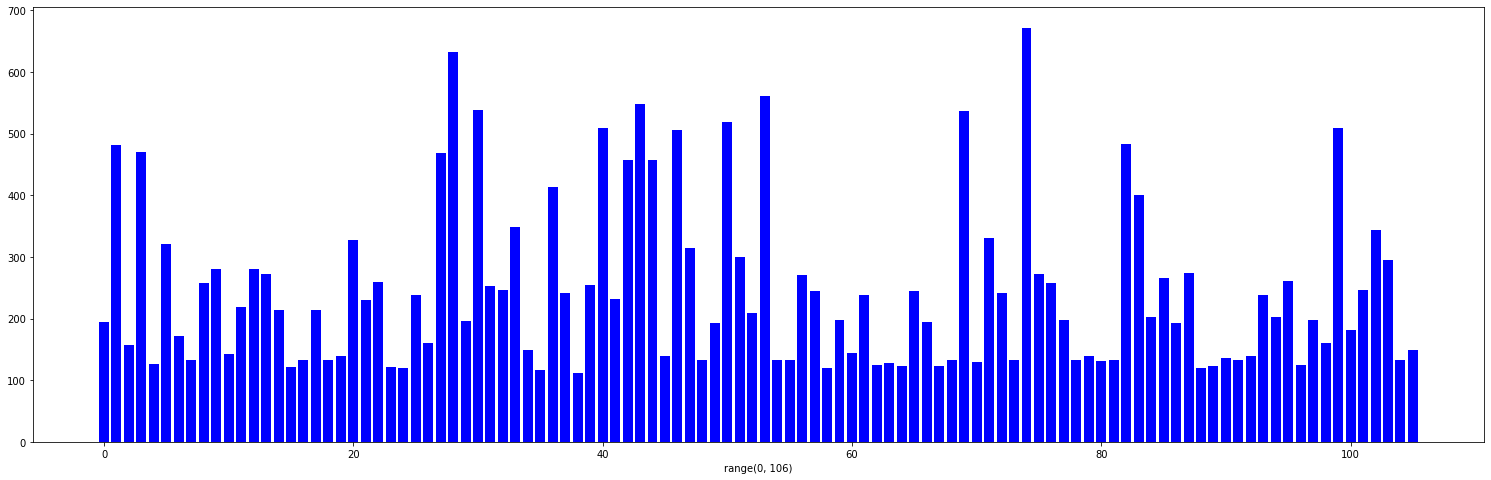

In [0]:
plt.figure(figsize=(26,8))
plt.bar(range(len(patients)), count,  color='b')
plt.xlabel(str(range(len(patients))))

In [0]:
print(sum(count))

26326


Let 's check a 10th patient:

In [0]:
ran_patient= INPUT_FOLDER+patients[10]+'/'+patients[10]

In [0]:
print(patients[10])

1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249.mhd


In [0]:
numpyImage, numpyOrigin, numpySpacing = load_itk_image(ran_patient)
print (numpyImage.shape)
print (numpyOrigin)
print (numpySpacing)

(143, 512, 512)
[-394.5 -220.  -199.3]
[2.5      0.859375 0.859375]


For the 10th patient, he got 143 slices of his lung CT scan

Let's see first image of a CT scan of 25 first patients

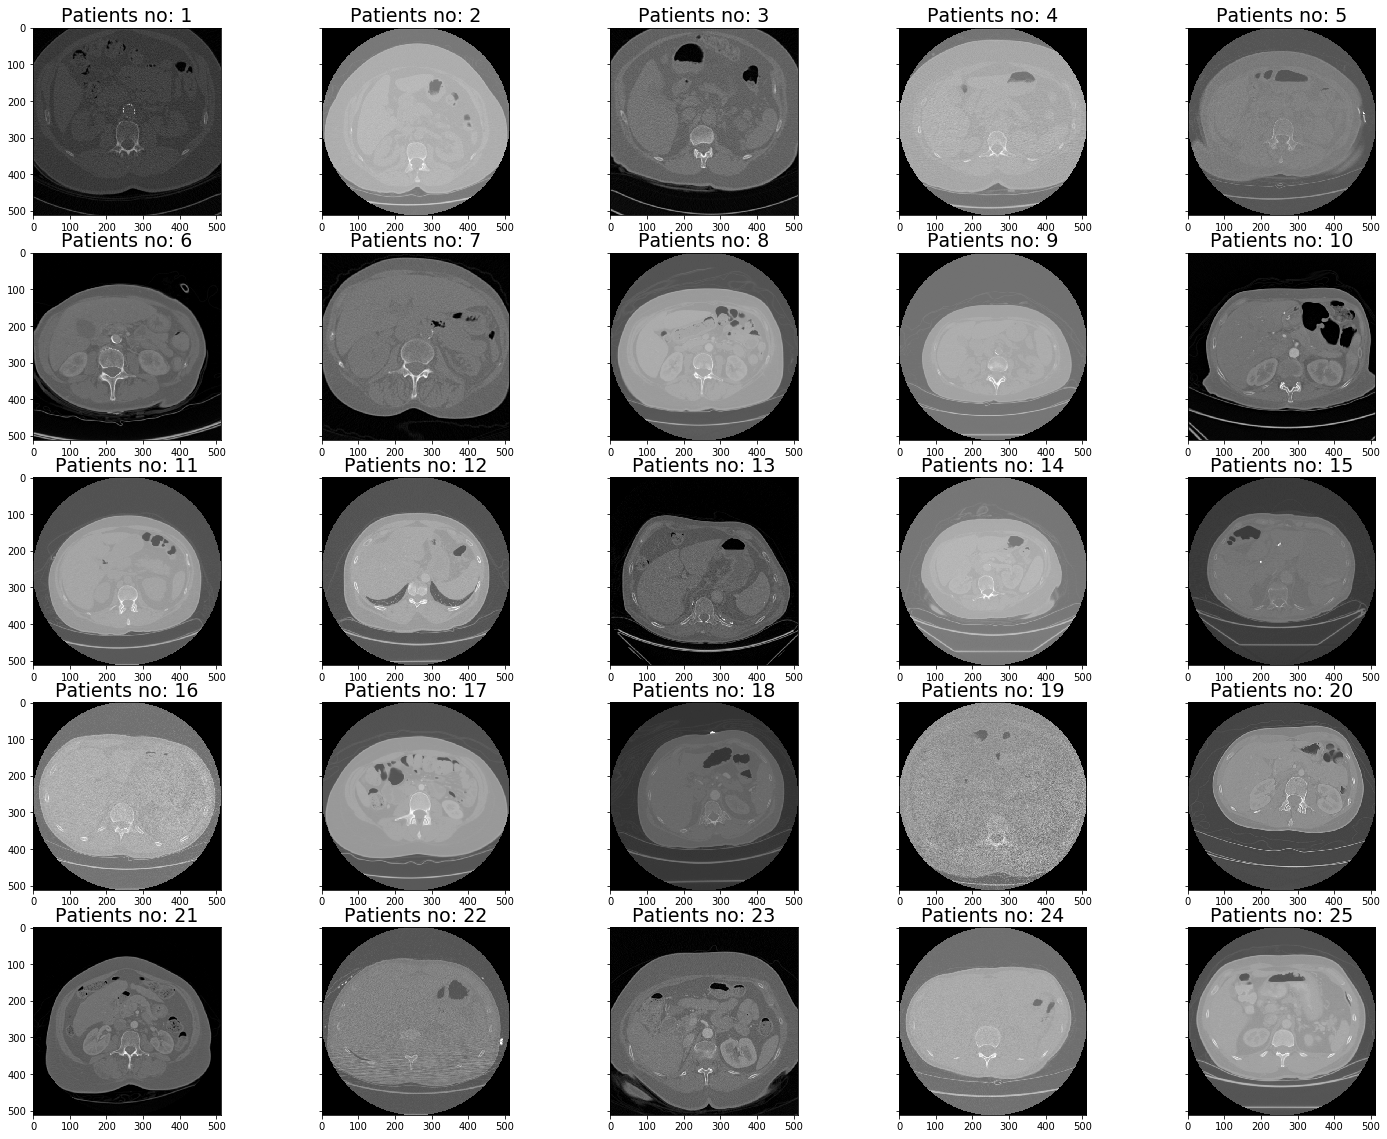

In [0]:
fig, axs = plt.subplots(5,5, figsize=(25, 20), sharey='row')
axs = axs.ravel()
for index, i in enumerate(range(0,25)):
    axs[index].imshow(load_itk_image(INPUT_FOLDER+patients[i]+'/'+patients[i])[0][0],cmap=plt.cm.gray)
    axs[index].set_title('Patients no: '+str(i+1),fontsize=19)
plt.show()


In [0]:
# plot functions
import scipy
def plot_2d(image,slice_step=5,col=4):   
    slice_per_row = slice_step * col
    row = int(image.shape[0]/slice_per_row)+1 # round up
    f, plots = plt.subplots(row, col, figsize=(20, 15))
    for i in range(0, image.shape[0], slice_step):
        plots[int(i / slice_per_row), int((i / slice_step) % col)].imshow(image[i], cmap=plt.cm.gray)
    for r in range(row):
        for c in range(col):
            plots[r, c].axis('off')
def plot_3d(image, floor=-700):
    # Floor: lowest DU that will be visible
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, floor)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
def resample(image, old_spacing, new_spacing=[1,1,1]):
    """
    Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    Parameters
    ----------
    image: numpy ndarray
    old_spacing: spacing of @image before scaled
    new_spacing: spacing of @image after scaled
    Return
    ------
    image: new scaled numpy array image
    new_spacing: can be different from the new_spacing in input
    """
    spacing = old_spacing
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    
    image = ndi.interpolation.zoom(image, real_resize_factor, mode='nearest')
    new_spacing = spacing / real_resize_factor
    
    return image, new_spacing

Above function is to reshape the image into a uniform format and ploting a serie of slice for one patient. Let's take a look for the 10th patient

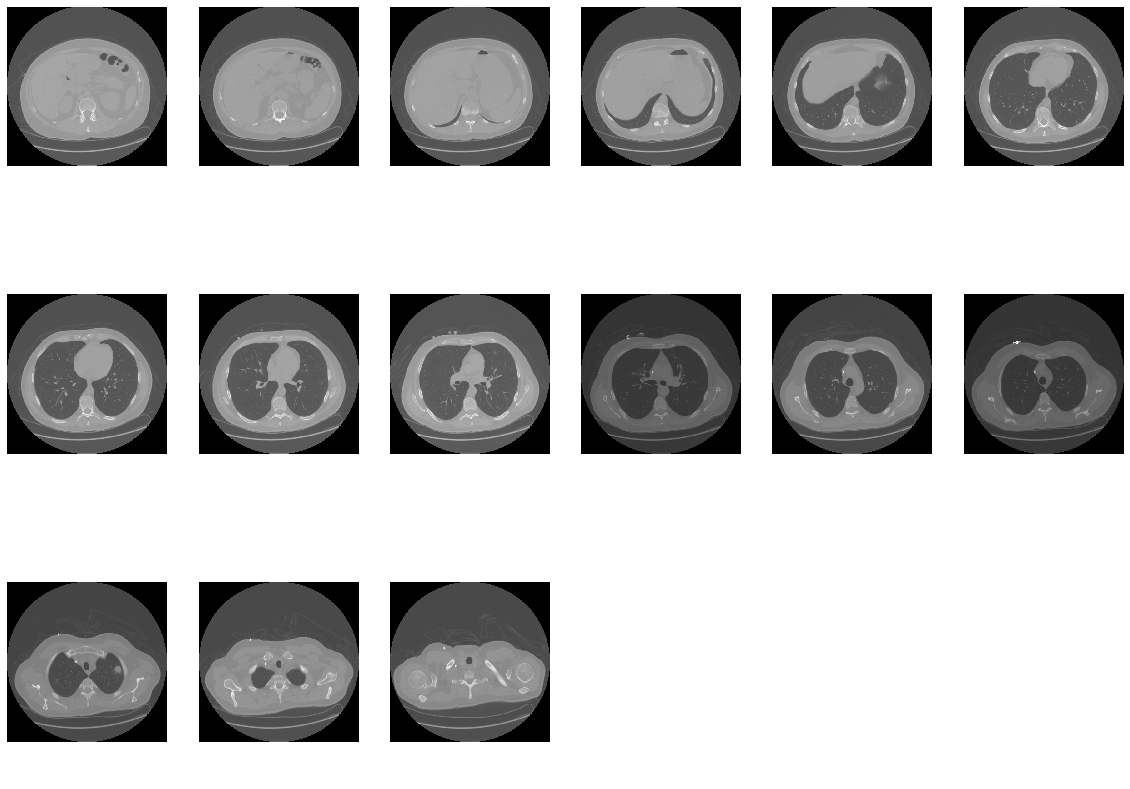

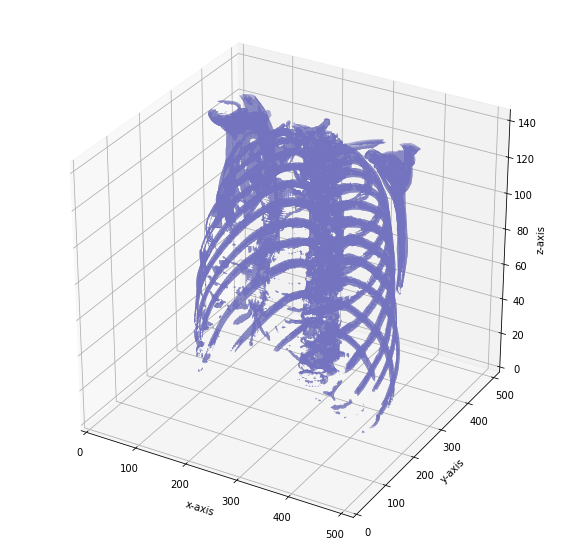

In [0]:
plot_2d(numpyImage,slice_step=10,col=6)
plot_3d(numpyImage,400)
plt.show()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


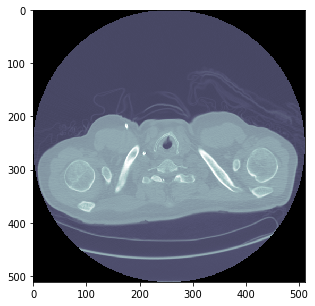

In [0]:
import matplotlib.animation as animation
def animate():
    fig =  plt.figure(figsize=(8,5))
    anim = plt.imshow(load_itk_image(ran_patient)[0][0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(load_itk_image(ran_patient)[0][i])
        return anim
    a= animation.FuncAnimation(fig, update, frames=np.arange(0, 143), interval=143)
    a.save('test.gif', writer='imagemagick', fps=15)
animate()

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

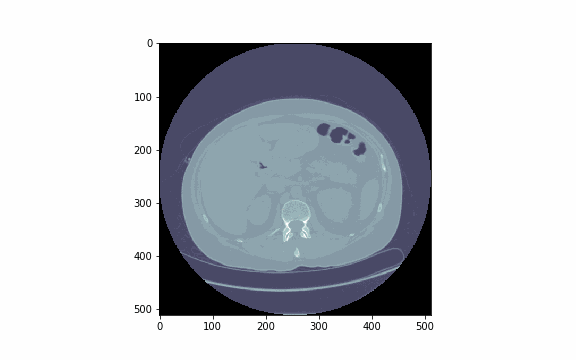

In [0]:
# Display GIF in Jupyter, CoLab, IPython
with open('test.gif','rb') as f:
    display.Image(data=f.read(), format='png')

# Data Processing

In [0]:
### data processing
candidates_pd = pd.read_csv('/content/candidates_V2/candidates_V2.csv')

In [0]:
candidates_pd['class'].value_counts()

0    753418
1      1557
Name: class, dtype: int64

In [0]:
print(candidates_pd['class'].value_counts()[1]/candidates_pd['class'].value_counts()[0]*100)

0.20665818974327665


The ratio of positive result is 0.2 % of the whole 2D slices scan.

In [0]:
candidates_pd.head()

seriesuid  ...  class
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0

[5 rows x 5 columns]

In [0]:
data=candidates_pd[0:0] 
for i in range(candidates_pd.shape[0]):
    if ( candidates_pd.seriesuid[i]+'.mhd' in patients):
        data = data.append(candidates_pd.loc[i])

In [0]:
data.head()

seriesuid  ...  class
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0

[5 rows x 5 columns]

One might realize that in this data set, the number of 2D slices are different with the number of labeled slices in the data frame, thus I would like to convert them into labeling 3D scan as followed. Please note that, in this assumption with a patient having more than 4 postive labeled slices in the data frame will be labeled positive in 3D case.

In [0]:
## take label 3D
label=[]
index=0
count=0
z=[]
for i in range(data.shape[0]):
    if (data.seriesuid[i]+'.mhd' == patients[index]):
        count=data['class'][i]+count
    else:
        z.append(count)
        if (count>4):
          label.append(1)
        else:
          label.append(0)
        index=index+1
        count=data['class'][i]
z.append(count)
## for the last element
if (count>4):
  label.append(1)
else:
  label.append(0)
print(len(label),index)


106 105


Before building the CNN model, all of the images data should be resized to be the same. In this report, our approach is to resize the whole 3D scan rather than finding the tumor region of interest.

In [0]:
### resize 3D image [20,50,50]
import math
import cv2

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 50
HM_SLICES = 20
data_process=[]
for num,patient in enumerate(patients):
    if num % 10 == 0:
      print(num)
    path = INPUT_FOLDER+patient+'/'+patient
    slices = load_itk_image(path)[0]
    new_slices = []
    slices = [cv2.resize(each_slice,(IMG_PX_SIZE,IMG_PX_SIZE),interpolation = cv2.INTER_AREA) for each_slice in slices]
    chunk_sizes = math.floor(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
      slice_chunk = list(map(mean, zip(*slice_chunk)))
      new_slices.append(slice_chunk)
      if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])
      if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
      if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
      if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    data_process.append(new_slices)
np.save('data_processed-{}-{}-{}.npy'.format(IMG_PX_SIZE,IMG_PX_SIZE,HM_SLICES), data_process)


0
10
20
30
40
50
60
70
80
90
100


Now let convert them into numpy array for easing in implementation

In [0]:
data_process=np.array(data_process)
label=np.array(label)

In [0]:
print(data_process.shape,label.shape)

(106, 20, 50, 50) (106,)


In [0]:
df = pd.DataFrame(list(label), columns = ['Label'])  
df.Label.value_counts()

0    95
1    11
Name: Label, dtype: int64

Amazingly, our data is not really imblance, we have 10 % of positive cancer. 

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data_process, label, test_size=0.1, random_state=12)
y_test_original = y_test

In [0]:
import keras
n_classes = 2
batch_size = 10
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)


Using TensorFlow backend.


Before going to the CNN model, To use 2D convolutions, we first convert every image into a 3D shape : width, height, channels. Channels represents the slices of Red, Green, and Blue layers. So it is set as 3. In the similar manner, we will convert the input dataset into 4D shape in order to use 3D convolution for : length, breadth, height, channel (r/g/b).
Reference: https://www.kaggle.com/shivamb/3d-convolutions-understanding-use-case by Shinvan Bansal

In [0]:
## Introduce the channel dimention in the input dataset 
xtrain = np.ndarray((x_train.shape[0], HM_SLICES,IMG_PX_SIZE,IMG_PX_SIZE, 4))
xtest = np.ndarray((x_test.shape[0], HM_SLICES,IMG_PX_SIZE,IMG_PX_SIZE, 4))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = plt.cm.ScalarMappable(cmap="Greys")
    array = scaler_map.to_rgba(array)
    return array
for i in range(x_train.shape[0]):
  for j in range (HM_SLICES):
    xtrain[i][j] = add_rgb_dimention(x_train[i][j])
for i in range(x_test.shape[0]):
  for j in range (HM_SLICES):
    xtest[i][j] = add_rgb_dimention(x_test[i][j])



Everything is ready, let's code out the model:

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Dropout, Input, BatchNormalization
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

In [0]:
# Define model
model = Sequential()
## input layer
input_layer = Input((HM_SLICES,IMG_PX_SIZE,IMG_PX_SIZE, 4))
## convolutional layers
model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',input_shape=(HM_SLICES,IMG_PX_SIZE,IMG_PX_SIZE, 4)))
model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu'))

## add max pooling to obtain the most imformatic features
model.add(MaxPool3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu'))
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPool3D(pool_size=(2, 2, 2)))

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
model.add(BatchNormalization())
model.add(Flatten())

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=2, activation='softmax'))
model.summary()



### STRUCTRE

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 18, 48, 48, 8)     872       
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 16, 46, 46, 16)    3472      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 8, 23, 23, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 6, 21, 21, 32)     13856     
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 4, 19, 19, 64)     55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 2, 9, 9, 64)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 9, 9, 64)      

In [0]:
''' to this 3D CNN 
https://www.kaggle.com/shivamb/3d-convolutions-understanding-use-case '''

' to this 3D CNN \nhttps://www.kaggle.com/shivamb/3d-convolutions-understanding-use-case '

In [0]:
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])

In [0]:
hist = model.fit(xtrain, y_train, validation_split=0.2,
          batch_size=batch_size,epochs = 15,shuffle=True)

Train on 76 samples, validate on 19 samples
Epoch 1/15
76/76 [==============================] - 20s 260ms/step - loss: 0.5029 - acc: 0.8421 - val_loss: 0.4004 - val_acc: 0.8947
Epoch 2/15
76/76 [==============================] - 18s 238ms/step - loss: 0.2556 - acc: 0.9211 - val_loss: 0.7385 - val_acc: 0.8421
Epoch 3/15
76/76 [==============================] - 18s 236ms/step - loss: 0.2045 - acc: 0.9211 - val_loss: 0.5918 - val_acc: 0.8421
Epoch 4/15
76/76 [==============================] - 18s 236ms/step - loss: 0.1166 - acc: 0.9474 - val_loss: 0.6867 - val_acc: 0.7895
Epoch 5/15
76/76 [==============================] - 18s 236ms/step - loss: 0.1031 - acc: 0.9605 - val_loss: 0.6142 - val_acc: 0.7895
Epoch 6/15
76/76 [==============================] - 18s 236ms/step - loss: 0.0560 - acc: 0.9868 - val_loss: 0.7062 - val_acc: 0.7895
Epoch 7/15
76/76 [==============================] - 18s 236ms/step - loss: 0.0744 - acc: 0.9605 - val_loss: 0.6159 - val_acc: 0.7895
Epoch 8/15
76/76 [=======

In [0]:
 # Evaluate the model
## check the accuracy
score, acc= model.evaluate(xtest, y_test,
                           batch_size=batch_size,
                           verbose=2)
print('Score value',score)
print('Accuracy',acc)
## report 
yhat_classes = model.predict_classes(xtest, verbose=0)
y_test_convert= [np.where(r==1)[0][0] for r in y_test]
print(classification_report(y_test_convert,yhat_classes)) # later


Score value 0.06794857843355699
Accuracy 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



# Conclusion and future work
In this report, we use the 3D CNN in stead of doing segmentation, this method is based on the compression of 3D CT images as input to the CNN. With this method, we can quickly indentify the possitive or nagtive cancer results of a patient without looking into details of the tumors size or shape. Based on the result with only 106 samples are trained, our model gave very promising performance, some fluctuation of the accuarcy appears may suggest that the accuarcy has been converged before finishing the epochs loop. Further of researching for re-considering the model and increase the number of samples should be applied. 

[1] https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial/comments